In [18]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 9.1 군집
### 9.1.1 k-평균

In [19]:
from sklearn.datasets import make_blobs

In [20]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [21]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [22]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [23]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [24]:
y_pred is kmeans.labels_

True

In [25]:
kmeans.cluster_centers_   # 5개의 센트로이트를 찾음

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [26]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**하드 군집 vs 소프트 군집**

하드 군집 은 각 샘플에 대해 가장 가까운 클러스터를 선택합니다. 이 대신 샘플에서 5개의 센트로이드까지 거리를 측정하는 것이 나을 수 있습니다. transform() 메서드에서 이 거리를 계산합니다.

In [27]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

**센트로이드 초기화 방법**

In [28]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

In [29]:
kmeans.score(X)

-211.59853725816836

**K-평균 속도 개선**

K-평균 알고리즘은 불필요한 거리 계산을 많이 피하는 식으로 속도를 크게 높일 수 있습니다. 이를 위해 삼각 부등식을 사용합니다.

**미니배치 K-평균**

사이킷런은 미니배치를 지원하는 K-평균 방식도 제공합니다

In [30]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [31]:
minibatch_kmeans.inertia_

211.65239850433215

**최적의 클러스터 개수 찾기**

1. 이니셔 이용

In [32]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

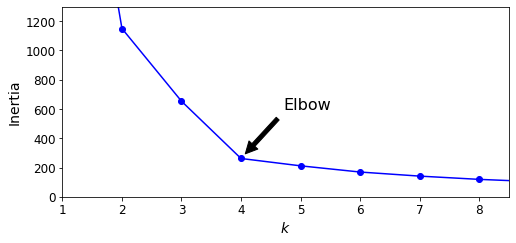

In [34]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

2. 실루엣 점수(실루엣 계수의 평균) 이용

In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [37]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

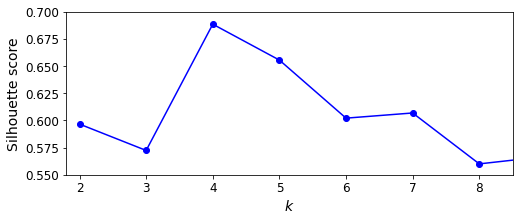

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

* 이 그래프는 이전보다 정보가 더 풍부합니다.
* 특히 k=4가 매우 좋은 선택이지만 k=5도 꽤 괜찮은 선택이라는 것을 보여줍니다.

### 9.1.4 군집을 사용한 전처리

In [39]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [40]:
# 훈련 세트와 테스트 세트로 나눕니다
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [41]:
# 로지스틱 회귀 모델을 훈련합니다.
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [42]:
# 테스트 세트에서 정확도를 평가합니다.
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

* 기준값으로 96.9% 정확도를 얻음

In [43]:
# K-평균을 전처리 단계로 사용해 더 향상할 수 있는지 알아 봅니다.
# 훈련 세트를 50개의 클러스터로 만들고 이미지를 이 클러스터까지 거리로 바꾼 다음 
# 로지스틱 회귀 모델을 적용하는 파이프라인을 만듭니다.
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [44]:
# 이 분류 파이프라인을 평가함
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

In [45]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

* 약 30%까지 오차율이 줄었음